# Feature Engineering for predicting loan status

In [49]:
# Standard imports
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.discretisation import EqualFrequencyDiscretiser

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from fast_ml.feature_engineering import FeatureEngineering_DateTime

# Built-in library
import itertools
import re
import json
import typing as tp

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# auto reload imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing and Loading the dataset
* Make a copy of the original dataset

In [2]:
df = pd.read_csv("selected_features.csv")
df1 = df.copy()
df1

,term,verification_status,loan_status,purpose,initial_list_status,application_type,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,36 months,Not Verified,Fully Paid,vacation,w,INDIVIDUAL,10000,11.44,329.48,4.467856,117000.0,26.24,16,0,36369,41.8,25,0,0
1,36 months,Not Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,8000,11.99,265.68,4.000000,65000.0,22.05,17,0,20131,53.3,27,3,0
2,36 months,Source Verified,Fully Paid,credit_card,f,INDIVIDUAL,15600,10.49,506.97,4.467856,43057.0,12.79,13,0,11987,92.2,26,0,0
3,36 months,Not Verified,Fully Paid,credit_card,f,INDIVIDUAL,7200,6.49,220.65,6.000000,54000.0,2.60,6,0,5472,21.5,13,0,0
4,60 months,Verified,Charged Off,credit_card,f,INDIVIDUAL,24375,17.27,609.33,9.000000,55000.0,33.95,13,0,24584,69.8,43,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,60 months,Source Verified,Fully Paid,debt_consolidation,w,INDIVIDUAL,10000,10.99,217.38,2.000000,40000.0,15.63,6,0,1990,34.3,23,0,0
396026,36 months,Source Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,21000,12.29,700.42,5.000000,110000.0,21.45,6,0,43263,95.7,8,1,0
396027,36 months,Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,5000,9.99,161.32,4.467856,56500.0,17.56,15,0,32704,66.9,23,0,0
396028,60 months,Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,21000,15.31,503.02,4.467856,64000.0,15.88,9,0,15704,53.8,20,5,0


* Display available information about the dataset and the shape of the dataset

In [3]:
df1.info(), df1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   term                  396030 non-null  object 
 1   verification_status   396030 non-null  object 
 2   loan_status           396030 non-null  object 
 3   purpose               396030 non-null  object 
 4   initial_list_status   396030 non-null  object 
 5   application_type      396030 non-null  object 
 6   loan_amnt             396030 non-null  int64  
 7   int_rate              396030 non-null  float64
 8   installment           396030 non-null  float64
 9   emp_length            396030 non-null  float64
 10  annual_inc            396030 non-null  float64
 11  dti                   396030 non-null  float64
 12  open_acc              396030 non-null  int64  
 13  pub_rec               396030 non-null  int64  
 14  revol_bal             396030 non-null  int64  
 15  

(None, (396030, 19))

## Feature Selection

* ### Check the Correlation of Features

* Subsets of features are evaluated by correlation feature selection based on the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

```
References:
M. Hal, Correlation-based Feature Selection for Machine Learning
```

In [4]:
def get_correlated_features(*, data: pd.DataFrame, threshold: float) -> list:
    """This is used to return a list of highly correlated features."""
    # Select only numeric data
    num_data = data.select_dtypes(include=[int, float])

    # Store the correlated columns
    col_corr = set()

    # Correlation matrix
    corr_matrix = num_data.corr()

    for i in range(len(corr_matrix.columns)):

        # check with other features
        for j in range(i):

            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:

                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(
                    f"correlation: {abs(corr_matrix.iloc[i, j])}, "
                    f"feat1:{corr_matrix.columns[i]}, feat2:{corr_matrix.columns[j]}"
                )

                # Get the name of the correlated feature
                col_name = corr_matrix.columns[j]

                # and add it to our correlated set
                col_corr.add(col_name)

    return list(col_corr)

In [5]:
get_correlated_features(data=df1, threshold=0.75)

correlation: 0.9539289082616145, feat1:installment, feat2:loan_amnt


['loan_amnt']

In [6]:
df1 = df1.drop(columns=["loan_amnt"])

In [7]:
df1

,term,verification_status,loan_status,purpose,initial_list_status,application_type,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,36 months,Not Verified,Fully Paid,vacation,w,INDIVIDUAL,11.44,329.48,4.467856,117000.0,26.24,16,0,36369,41.8,25,0,0
1,36 months,Not Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,11.99,265.68,4.000000,65000.0,22.05,17,0,20131,53.3,27,3,0
2,36 months,Source Verified,Fully Paid,credit_card,f,INDIVIDUAL,10.49,506.97,4.467856,43057.0,12.79,13,0,11987,92.2,26,0,0
3,36 months,Not Verified,Fully Paid,credit_card,f,INDIVIDUAL,6.49,220.65,6.000000,54000.0,2.60,6,0,5472,21.5,13,0,0
4,60 months,Verified,Charged Off,credit_card,f,INDIVIDUAL,17.27,609.33,9.000000,55000.0,33.95,13,0,24584,69.8,43,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,60 months,Source Verified,Fully Paid,debt_consolidation,w,INDIVIDUAL,10.99,217.38,2.000000,40000.0,15.63,6,0,1990,34.3,23,0,0
396026,36 months,Source Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,12.29,700.42,5.000000,110000.0,21.45,6,0,43263,95.7,8,1,0
396027,36 months,Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,9.99,161.32,4.467856,56500.0,17.56,15,0,32704,66.9,23,0,0
396028,60 months,Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,15.31,503.02,4.467856,64000.0,15.88,9,0,15704,53.8,20,5,0


###  Mutual information

* Using mutual information, we can measure how much uncertainty is reduced in variable A when we know variable B. 
* To select variables, we are interested in the mutual information between the predictor variables and the target. Higher mutual information values, indicate little uncertainty about the target Y given the predictor X.

In [8]:
from sklearn.model_selection import train_test_split

# Mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.linear_model import LogisticRegression


RANDOM_STATE = 123
TEST_SIZE = 0.2
TARGET = "loan_status"

In [9]:
df2 = df1.copy()
X = df2.drop(columns=[TARGET])
y = df2[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((316824, 17), (79206, 17))

In [10]:
y_train.shape, y_test.shape

((316824,), (79206,))

In [11]:
y_train2 = pd.DataFrame(y_train)
y_train2

,loan_status
339881,Fully Paid
134266,Fully Paid
52251,Fully Paid
173331,Fully Paid
288890,Fully Paid
...,...
192476,Fully Paid
17730,Fully Paid
28030,Charged Off
277869,Fully Paid


In [12]:
X_train

,term,verification_status,purpose,initial_list_status,application_type,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
339881,36 months,Source Verified,debt_consolidation,f,INDIVIDUAL,19.72,388.73,4.467856,30000.0,25.14,6,0,21832,97.0,10,0,0
134266,36 months,Not Verified,debt_consolidation,f,INDIVIDUAL,13.11,371.20,4.000000,104000.0,11.88,15,0,9637,46.7,44,1,0
52251,36 months,Source Verified,debt_consolidation,f,INDIVIDUAL,5.42,226.20,4.000000,80000.0,5.54,9,0,7125,16.8,24,1,0
173331,36 months,Not Verified,credit_card,w,INDIVIDUAL,6.03,319.58,4.000000,106000.0,16.73,19,0,22791,25.2,40,0,0
288890,36 months,Source Verified,credit_card,f,INDIVIDUAL,6.49,735.47,4.467856,105000.0,8.46,7,0,36115,57.7,24,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,36 months,Source Verified,major_purchase,f,INDIVIDUAL,10.74,487.61,4.467856,94500.0,5.55,9,0,15246,46.8,25,0,0
17730,36 months,Not Verified,credit_card,f,INDIVIDUAL,9.99,387.15,4.467856,100000.0,12.71,12,0,14764,45.0,26,3,0
28030,60 months,Source Verified,credit_card,w,INDIVIDUAL,11.53,550.20,4.467856,160000.0,9.03,6,0,7468,47.3,20,4,0
277869,36 months,Verified,credit_card,f,INDIVIDUAL,9.80,675.65,9.000000,310000.0,10.72,8,0,32466,86.0,32,6,0


In [13]:
# Splitting the trainset into categorical and numerical data, to check mutual information
x_num_variables = X_train.select_dtypes(exclude='object')
y_num_variables = y_train2.select_dtypes(exclude='object')
x_num_variables.shape, y_num_variables.shape

((316824, 12), (316824, 0))

In [14]:
# Calculate the mutual information between the variables and the target
# Note: The lower the mi value, the less can be inferred about the target from the feature.

# You should consider scaling the features



MI = mutual_info_classif(x_num_variables, y_train, random_state=RANDOM_STATE)
MI

array([0.0383643 , 0.02358499, 0.01348142, 0.00567688, 0.00844654,
       0.00343536, 0.00178064, 0.00048264, 0.00302942, 0.00111666,
       0.00635335, 0.00143474])

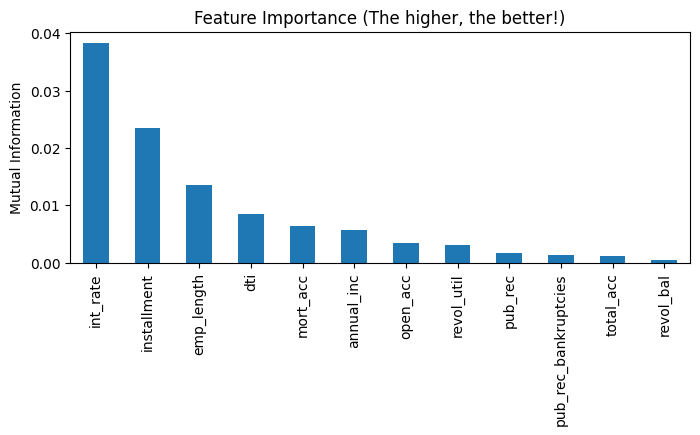

In [15]:
# Visualize The Feature Importance

feat_importance = pd.Series(MI)
feat_importance.index = x_num_variables.columns
feat_importance.sort_values(ascending=False).plot(
    kind="bar",
    ylabel="Mutual Information",
    title="Feature Importance (The higher, the better!)",
    figsize=(8, 3),
)
plt.show()

Due to the fact that higher is better, I will drop the last four features with very low mutual information

In [16]:
df3 = df1.drop(columns=["revol_bal", "total_acc", "pub_rec_bankruptcies", "pub_rec"])
df3.head(4)

,term,verification_status,loan_status,purpose,initial_list_status,application_type,int_rate,installment,emp_length,annual_inc,dti,open_acc,revol_util,mort_acc
0,36 months,Not Verified,Fully Paid,vacation,w,INDIVIDUAL,11.44,329.48,4.467856,117000.0,26.24,16,41.8,0
1,36 months,Not Verified,Fully Paid,debt_consolidation,f,INDIVIDUAL,11.99,265.68,4.000000,65000.0,22.05,17,53.3,3
2,36 months,Source Verified,Fully Paid,credit_card,f,INDIVIDUAL,10.49,506.97,4.467856,43057.0,12.79,13,92.2,0
3,36 months,Not Verified,Fully Paid,credit_card,f,INDIVIDUAL,6.49,220.65,6.000000,54000.0,2.60,6,21.5,0


The column "initial_list_status", was obtained from a site that can be used to identify whether each loan was funded through the “whole” or “fractional” program. This was used to compare aggregate portfolio selection and performance between two classes of investors, institutional (corresponding to whole loan purchasers) and retail (fractional or note purchasers). It showed strong evidence that institutional investors prefer to fund loans whose borrowers will prepay long before the maturity date, which can potentially be explained by structural features of the marketplace. This information can only be obtained, after a borrower defaults or repays. Hence I will drop the column to prevent data leakage.

In [17]:
df3 = df3.drop(columns=["initial_list_status"])

The columns "int_rate" and "installment" contain information gotten only after, a loan is given which could potentially lead to data leakage

In [18]:
df3 = df3.drop(columns=["int_rate", "installment"])

In [19]:
df3['verification_status'] = df3['verification_status'].replace('Source Verified','Verified')
df3['verification_status'].value_counts(normalize = True)


verification_status
Verified        0.68416
Not Verified    0.31584
Name: proportion, dtype: float64

In [20]:
df3.info(), df3.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   term                 396030 non-null  object 
 1   verification_status  396030 non-null  object 
 2   loan_status          396030 non-null  object 
 3   purpose              396030 non-null  object 
 4   application_type     396030 non-null  object 
 5   emp_length           396030 non-null  float64
 6   annual_inc           396030 non-null  float64
 7   dti                  396030 non-null  float64
 8   open_acc             396030 non-null  int64  
 9   revol_util           396030 non-null  float64
 10  mort_acc             396030 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 33.2+ MB


(None, (396030, 11))

### Rename the colunms

In [21]:
df3.columns

Index(['term', 'verification_status', 'loan_status', 'purpose',
       'application_type', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'revol_util', 'mort_acc'],
      dtype='object')

In [22]:
df3.rename(columns = {'term':'Loan Term',
                      'verification_status':'Verification by Loan Company',                                        
                      'purpose':'Loan Purpose', 
                      'application_type':'Application Type', 
                      'emp_length':'Total Years of Employment', 
                      'annual_inc':'Annual Income',
                      'mort_acc':'No of Mortgage Account',
                      'loan_status':'Loan Status',
                      'dti':'Income-Debt Ratio',
                      'open_acc':'No of Open Credit Lines',
                      'revol_util':'Credit Utilization Rate'}, 
                      inplace = True)

In [23]:
df3.info(), df3.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan Term                     396030 non-null  object 
 1   Verification by Loan Company  396030 non-null  object 
 2   Loan Status                   396030 non-null  object 
 3   Loan Purpose                  396030 non-null  object 
 4   Application Type              396030 non-null  object 
 5   Total Years of Employment     396030 non-null  float64
 6   Annual Income                 396030 non-null  float64
 7   Income-Debt Ratio             396030 non-null  float64
 8   No of Open Credit Lines       396030 non-null  int64  
 9   Credit Utilization Rate       396030 non-null  float64
 10  No of Mortgage Account        396030 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 33.2+ MB


(None, (396030, 11))

In [24]:
df3.to_csv('predictive_features.csv', index=False)

### Pipeline for Feature Engineering

In [25]:
df4 = df3.copy()
df4

,Loan Term,Verification by Loan Company,Loan Status,Loan Purpose,Application Type,Total Years of Employment,Annual Income,Income-Debt Ratio,No of Open Credit Lines,Credit Utilization Rate,No of Mortgage Account
0,36 months,Not Verified,Fully Paid,vacation,INDIVIDUAL,4.467856,117000.0,26.24,16,41.8,0
1,36 months,Not Verified,Fully Paid,debt_consolidation,INDIVIDUAL,4.000000,65000.0,22.05,17,53.3,3
2,36 months,Verified,Fully Paid,credit_card,INDIVIDUAL,4.467856,43057.0,12.79,13,92.2,0
3,36 months,Not Verified,Fully Paid,credit_card,INDIVIDUAL,6.000000,54000.0,2.60,6,21.5,0
4,60 months,Verified,Charged Off,credit_card,INDIVIDUAL,9.000000,55000.0,33.95,13,69.8,1
...,...,...,...,...,...,...,...,...,...,...,...
396025,60 months,Verified,Fully Paid,debt_consolidation,INDIVIDUAL,2.000000,40000.0,15.63,6,34.3,0
396026,36 months,Verified,Fully Paid,debt_consolidation,INDIVIDUAL,5.000000,110000.0,21.45,6,95.7,1
396027,36 months,Verified,Fully Paid,debt_consolidation,INDIVIDUAL,4.467856,56500.0,17.56,15,66.9,0
396028,60 months,Verified,Fully Paid,debt_consolidation,INDIVIDUAL,4.467856,64000.0,15.88,9,53.8,5


In [26]:
TARGET = "Loan Status"
RANDOM_STATE = 123
TEST_SIZE = 0.2

# Split the data into features (x) and the target variable (y)
x = df4.drop(columns=TARGET)
y = df4[TARGET]

# Split the data
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [27]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan Term                     396030 non-null  object 
 1   Verification by Loan Company  396030 non-null  object 
 2   Loan Status                   396030 non-null  object 
 3   Loan Purpose                  396030 non-null  object 
 4   Application Type              396030 non-null  object 
 5   Total Years of Employment     396030 non-null  float64
 6   Annual Income                 396030 non-null  float64
 7   Income-Debt Ratio             396030 non-null  float64
 8   No of Open Credit Lines       396030 non-null  int64  
 9   Credit Utilization Rate       396030 non-null  float64
 10  No of Mortgage Account        396030 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 33.2+ MB


In [28]:
df4["Total Years of Employment"].unique(), df4["Total Years of Employment"].nunique() 

(array([4.46785596, 4.        , 6.        , 9.        , 2.        ,
        3.        , 8.        , 7.        , 5.        , 1.        ]),
 10)

In [29]:
df4["Annual Income"].unique(), df4["Annual Income"].nunique() #dicretize

(array([117000.  ,  65000.  ,  43057.  , ...,  36111.  ,  47212.  ,
         31789.88]),
 27197)

In [30]:
df4["Income-Debt Ratio"].unique(), df4["Income-Debt Ratio"].nunique() #dicretize

(array([26.24, 22.05, 12.79, ..., 40.56, 47.09, 55.53]), 4262)

In [31]:
df4["No of Open Credit Lines"].unique(), df4["No of Open Credit Lines"].nunique() #dicretize

(array([16, 17, 13,  6,  8, 11,  5, 30,  9, 15, 12, 10, 18,  7,  4, 14, 20,
        19, 21, 23,  3, 26, 42, 22, 25, 28,  2, 34, 24, 27, 31, 32, 33,  1,
        29, 36, 40, 35, 37, 41, 44, 39, 49, 48, 38, 51, 50, 43, 46,  0, 47,
        57, 53, 58, 52, 54, 45, 90, 56, 55, 76], dtype=int64),
 61)

In [32]:
df4["Credit Utilization Rate"].unique(), df4["Credit Utilization Rate"].nunique() #discretize

(array([ 41.8 ,  53.3 ,  92.2 , ...,  56.26, 111.4 , 128.1 ]), 1226)

In [33]:
df4["No of Mortgage Account"].unique(), df4["No of Mortgage Account"].nunique() #discretize

(array([ 0,  3,  1,  4,  2,  6,  5, 10,  7, 12, 11,  8,  9, 13, 14, 22, 34,
        15, 25, 19, 16, 17, 32, 18, 24, 21, 20, 31, 28, 30, 23, 26, 27],
       dtype=int64),
 33)

In [34]:
columns_to_dicretize = ["Annual Income", "Income-Debt Ratio", "No of Open Credit Lines", "Credit Utilization Rate", "No of Mortgage Account"]
rare_label_columns = ['Loan Purpose', 'Application Type']
columns_to_encode = ['Loan Term', 'Verification by Loan Company', 'Loan Purpose', 'Application Type'] 
REPL_VARS_WITH_MEDIAN = ["Annual Income", "Income-Debt Ratio", "No of Open Credit Lines", "Credit Utilization Rate", "No of Mortgage Account", "Total Years of Employment"]
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['Loan Term', 'Verification by Loan Company', 'Loan Purpose', 'Application Type']

In [35]:
feat_eng_pipe = Pipeline(
    steps=[
                # ========== IMPUTATION ==========
        # Impute numerical variables with the median
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median", variables=REPL_VARS_WITH_MEDIAN
            ),
        ),
        (
            "frequent_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=CATEGORICAL_VARS_WITH_NA_FREQUENT,
            ),
        ),
        # ========== DISCRETIZE NUMERICAL VARIABLES ==========
        (
            "discretizer",
            EqualFrequencyDiscretiser(
                variables=columns_to_dicretize,
                q=10,
            ),
        ),
        # ========== REMOVE RARE LABELS ==========
        (
            "rare_labels",
            RareLabelEncoder(tol=0.05, n_categories=2, 
                             variables=rare_label_columns, 
                             replace_with = 'Others'),
        ),
        # ========== ENCODE CATEGORICAL VARIABLES ==========
        (
            "OneHotEncoder",
            OneHotEncoder(top_categories=None, drop_last=True,  
            variables=columns_to_encode, ignore_format=False),
        ),
        # ========== SCALE NUMERICAL VARIABLES ==========
        (
            "scaler",
            StandardScaler()
        ),
    ],
)

feat_eng_pipe

Pipeline(steps=[('median_imputation',
                 MeanMedianImputer(variables=['Annual Income',
                                              'Income-Debt Ratio',
                                              'No of Open Credit Lines',
                                              'Credit Utilization Rate',
                                              'No of Mortgage Account',
                                              'Total Years of Employment'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Loan Term',
                                               'Verification by Loan Company',
                                               'Loan Purpose',
                                               'Application Type'])...
                                                      'Income-Debt Ratio',
                                                      'No of Open Credit Lines',
                                                      'Credit Utilization Rate',
                                                      'No of Mortgage '
                                                      'Account'])),
                ('rare_labels',
                 RareLabelEncoder(n_categories=2, replace_with='Others',
                                  variables=['Loan Purpose',
                                             'Application Type'])),
                ('OneHotEncoder',
                 OneHotEncoder(drop_last=True,
                               variables=['Loan Term',
                                          'Verification by Loan Company',
                                          'Loan Purpose',
                                          'Application Type'])),
                ('scaler', StandardScaler())])

In [36]:
# Train the pipeline
feat_eng_pipe.fit(x_train, y_train)

Pipeline(steps=[('median_imputation',
                 MeanMedianImputer(variables=['Annual Income',
                                              'Income-Debt Ratio',
                                              'No of Open Credit Lines',
                                              'Credit Utilization Rate',
                                              'No of Mortgage Account',
                                              'Total Years of Employment'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Loan Term',
                                               'Verification by Loan Company',
                                               'Loan Purpose',
                                               'Application Type'])...
                                                      'Income-Debt Ratio',
                                                      'No of Open Credit Lines',
                                                      'Credit Utilization Rate',
                                                      'No of Mortgage '
                                                      'Account'])),
                ('rare_labels',
                 RareLabelEncoder(n_categories=2, replace_with='Others',
                                  variables=['Loan Purpose',
                                             'Application Type'])),
                ('OneHotEncoder',
                 OneHotEncoder(drop_last=True,
                               variables=['Loan Term',
                                          'Verification by Loan Company',
                                          'Loan Purpose',
                                          'Application Type'])),
                ('scaler', StandardScaler())])

In [37]:
# Apply the pipeline to train and test data
# x_train = feat_eng_pipe.transform(x_train)
# x_test = feat_eng_pipe.transform(x_test)

In [38]:
# Train the pipeline
features = feat_eng_pipe.fit_transform(x_train, y_train)
pd.DataFrame(features, columns=feat_eng_pipe.get_feature_names_out()).head()

,Total Years of Employment,Annual Income,Income-Debt Ratio,No of Open Credit Lines,Credit Utilization Rate,No of Mortgage Account,Loan Term_36 months,Verification by Loan Company_Verified,Loan Purpose_debt_consolidation,Loan Purpose_credit_card,Loan Purpose_Others,Loan Purpose_home_improvement,Application Type_INDIVIDUAL
0,-0.001250,-1.531021,1.219182,-1.456442,1.568219,-0.697304,0.5576,0.679130,0.829089,-0.514898,-0.302824,-0.253412,0.042004
1,-0.254843,1.224599,-0.869696,0.942648,-0.520505,-0.697304,0.5576,-1.472473,0.829089,-0.514898,-0.302824,-0.253412,0.042004
2,-0.254843,0.535694,-1.565988,-0.428261,-1.564867,-0.697304,0.5576,0.679130,0.829089,-0.514898,-0.302824,-0.253412,0.042004
3,-0.254843,1.224599,-0.173403,1.628102,-1.216747,-0.697304,0.5576,-1.472473,-1.206143,1.942132,-0.302824,-0.253412,0.042004
4,-0.001250,1.224599,-1.217842,-1.113715,0.175736,2.370809,0.5576,0.679130,-1.206143,1.942132,-0.302824,-0.253412,0.042004


# MODEL BUILDING

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [40]:
# init xgboost
xgb_estimator = XGBClassifier(booster = "gbtree", random_state = 123, n_jobs=4)

In [41]:
smote = SMOTE(random_state = 123)

In [42]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()

In [43]:
y_train = LabelEncoder.fit_transform(y_train)
y_test = LabelEncoder.fit_transform(y_test)

In [44]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
pipe_xgboost = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== xgboostmodel Model =====
        ("xgb_estimator", xgb_estimator),
    ]
)

pipe_xgboost

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('median_imputation',
                                  MeanMedianImputer(variables=['Annual Income',
                                                               'Income-Debt '
                                                               'Ratio',
                                                               'No of Open '
                                                               'Credit Lines',
                                                               'Credit '
                                                               'Utilization '
                                                               'Rate',
                                                               'No of Mortgage '
                                                               'Account',
                                                               'Total Years of '
                                                               'Employment'])),
                                 ('frequent_imputation',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['Loan Term',
                                                                'Verification '
                                                                'b...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=4, num_parallel_tree=None, predictor=None,
                               random_state=123, ...))])

In [46]:
# Fit
pipe_xgboost.fit(x_train, y_train)

# Make predictions
y_pred_1 = pipe_xgboost.predict(x_test)

In [47]:
y_pred_1

array([1, 1, 1, ..., 1, 1, 1])

# MODEL EVALUATION

### XGBOOST MODEL EVALUATION

              precision    recall  f1-score   support

           0       0.52      0.04      0.07     15501
           1       0.81      0.99      0.89     63705

    accuracy                           0.80     79206
   macro avg       0.66      0.51      0.48     79206
weighted avg       0.75      0.80      0.73     79206



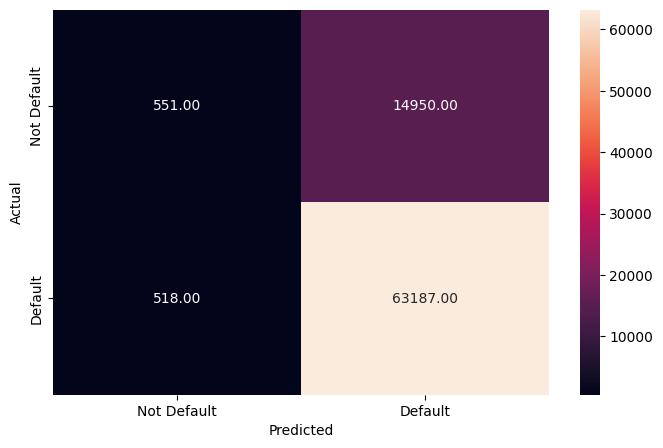

In [52]:
#creating metric function 
def metrics_score(actual, predicted):
    print(metrics.classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
metrics_score(y_test, y_pred_1)

In [53]:
print("-------------------------TEST SCORES-----------------------") 
print(f"Recall: { round(recall_score(y_test, y_pred_1)*100, 4) }")
print(f"Precision: { round(precision_score(y_test, y_pred_1)*100, 4) }")
print(f"F1-Score: { round(f1_score(y_test, y_pred_1)*100, 4) }")
print(f"Accuracy score: { round(accuracy_score(y_test, y_pred_1)*100, 4) }")
print(f"AUC Score: { round(roc_auc_score(y_test, y_pred_1)*100, 4) }")

-------------------------TEST SCORES-----------------------
Recall: 99.1869
Precision: 80.8669
F1-Score: 89.0949
Accuracy score: 80.4712
AUC Score: 51.3707


In [54]:
result = pd.DataFrame()
result["Actual"] = y_test
result["Predicted"] = y_pred_1
result["Error"] = y_test - y_pred_1

result.head(10)

,Actual,Predicted,Error
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,0,1,-1
5,1,1,0
6,1,1,0
7,1,1,0
8,1,1,0
9,1,1,0


In [55]:
# joblib.dump("C:\Users\Kofo\OneDrive\Desktop\Loan_prediction_project\Loan_prediction_model.py")

# Ignore the cells below, they are further experimentation

### RANDOM FOREST MODEL

In [56]:
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Instantiate
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [57]:
# RANDOM FOREST MODEL
pipe_random_forest_model = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== random_forest_model =====
        ("random_forest_model", random_forest_model),
    ]
)

pipe_random_forest_model

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('median_imputation',
                                  MeanMedianImputer(variables=['Annual Income',
                                                               'Income-Debt '
                                                               'Ratio',
                                                               'No of Open '
                                                               'Credit Lines',
                                                               'Credit '
                                                               'Utilization '
                                                               'Rate',
                                                               'No of Mortgage '
                                                               'Account',
                                                               'Total Years of '
                                                               'Employment'])),
                                 ('frequent_imputation',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['Loan Term',
                                                                'Verification '
                                                                'b...
                                                                       'Account'])),
                                 ('rare_labels',
                                  RareLabelEncoder(n_categories=2,
                                                   replace_with='Others',
                                                   variables=['Loan Purpose',
                                                              'Application '
                                                              'Type'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Loan Term',
                                                           'Verification by '
                                                           'Loan Company',
                                                           'Loan Purpose',
                                                           'Application '
                                                           'Type'])),
                                 ('scaler', StandardScaler())])),
                ('random_forest_model',
                 RandomForestClassifier(random_state=123))])

In [58]:
# Fit
pipe_random_forest_model.fit(x_train, y_train)

# Make predictions
y_pred_2 = pipe_random_forest_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.30      0.14      0.19     15501
           1       0.81      0.92      0.87     63705

    accuracy                           0.77     79206
   macro avg       0.56      0.53      0.53     79206
weighted avg       0.71      0.77      0.73     79206



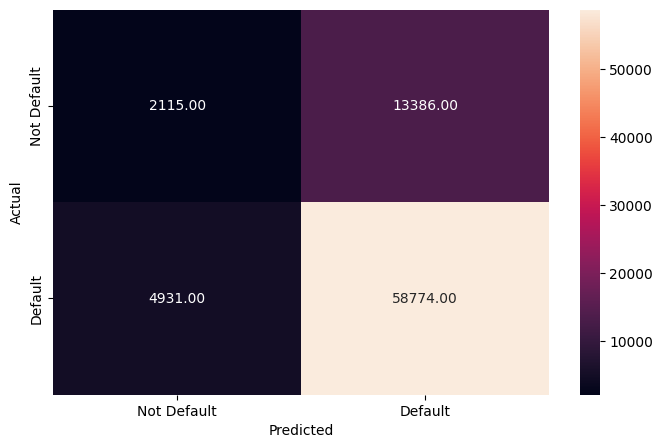

In [59]:
#creating metric function 
def metrics_score(actual, predicted):
    print(metrics.classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
metrics_score(y_test, y_pred_2)

In [60]:
print("-------------------------TEST SCORES-----------------------") 
print(f"Recall: { round(recall_score(y_test, y_pred_2)*100, 4) }")
print(f"Precision: { round(precision_score(y_test, y_pred_2)*100, 4) }")
print(f"F1-Score: { round(f1_score(y_test, y_pred_2)*100, 4) }")
print(f"Accuracy score: { round(accuracy_score(y_test, y_pred_2)*100, 4) }")
print(f"AUC Score: { round(roc_auc_score(y_test, y_pred_2)*100, 4) }")

-------------------------TEST SCORES-----------------------
Recall: 92.2596
Precision: 81.4496
F1-Score: 86.5182
Accuracy score: 76.8742
AUC Score: 52.952


### LOGISTIC REGRESSION MODEL

In [61]:
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 123

# Init
logit = LogisticRegression(random_state=RANDOM_STATE)

In [62]:
# RANDOM FOREST MODEL
logit_model = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== logit model =====
        ("logit model", logit),
    ]
)

logit_model

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('median_imputation',
                                  MeanMedianImputer(variables=['Annual Income',
                                                               'Income-Debt '
                                                               'Ratio',
                                                               'No of Open '
                                                               'Credit Lines',
                                                               'Credit '
                                                               'Utilization '
                                                               'Rate',
                                                               'No of Mortgage '
                                                               'Account',
                                                               'Total Years of '
                                                               'Employment'])),
                                 ('frequent_imputation',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['Loan Term',
                                                                'Verification '
                                                                'b...
                                                                       'Mortgage '
                                                                       'Account'])),
                                 ('rare_labels',
                                  RareLabelEncoder(n_categories=2,
                                                   replace_with='Others',
                                                   variables=['Loan Purpose',
                                                              'Application '
                                                              'Type'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Loan Term',
                                                           'Verification by '
                                                           'Loan Company',
                                                           'Loan Purpose',
                                                           'Application '
                                                           'Type'])),
                                 ('scaler', StandardScaler())])),
                ('logit model', LogisticRegression(random_state=123))])

In [63]:
# Fit
logit_model.fit(x_train, y_train)

# Make predictions
y_pred_3 = logit_model.predict(x_test)

In [64]:
# Probability of default
y_proba_1 = logit_model.predict_proba(x_test)[:, 1]

              precision    recall  f1-score   support

           0       0.52      0.02      0.04     15501
           1       0.81      1.00      0.89     63705

    accuracy                           0.80     79206
   macro avg       0.66      0.51      0.47     79206
weighted avg       0.75      0.80      0.73     79206



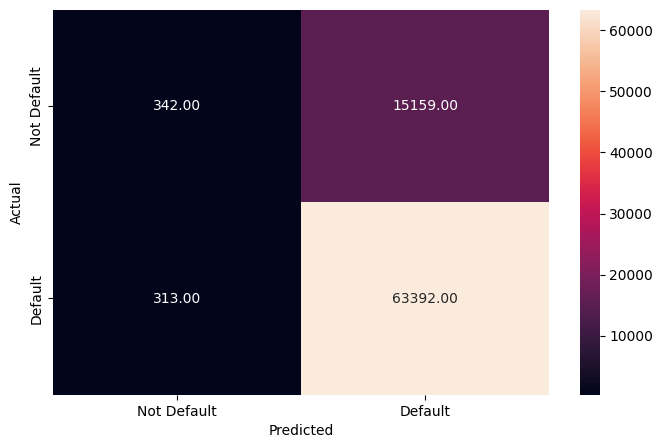

In [65]:
#creating metric function 
def metrics_score(actual, predicted):
    print(metrics.classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
metrics_score(y_test, y_pred_3)

In [66]:
print("-------------------------TEST SCORES-----------------------") 
print(f"Recall: { round(recall_score(y_test, y_pred_3, pos_label=1)*100, 4) }")
print(f"Precision: { round(precision_score(y_test, y_pred_3, pos_label=1)*100, 4) }")
print(f"F1-Score: { round(f1_score(y_test, y_pred_3, pos_label=1)*100, 4) }")
print(f"Accuracy score: { round(accuracy_score(y_test, y_pred_3)*100, 4) }")
print(f"AUC Score: { round(roc_auc_score(y_test, y_proba_1)*100, 4) }")

-------------------------TEST SCORES-----------------------
Recall: 99.5087
Precision: 80.7017
F1-Score: 89.1238
Accuracy score: 80.4661
AUC Score: 67.1985


### DECISION TREE MODEL

In [67]:
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 123

# Init
clf = DecisionTreeClassifier()

In [68]:
# decision tree MODEL
clf_model = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== clf model =====
        ("clf model", clf),
    ]
)

clf_model

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('median_imputation',
                                  MeanMedianImputer(variables=['Annual Income',
                                                               'Income-Debt '
                                                               'Ratio',
                                                               'No of Open '
                                                               'Credit Lines',
                                                               'Credit '
                                                               'Utilization '
                                                               'Rate',
                                                               'No of Mortgage '
                                                               'Account',
                                                               'Total Years of '
                                                               'Employment'])),
                                 ('frequent_imputation',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['Loan Term',
                                                                'Verification '
                                                                'b...
                                                                       'No of '
                                                                       'Mortgage '
                                                                       'Account'])),
                                 ('rare_labels',
                                  RareLabelEncoder(n_categories=2,
                                                   replace_with='Others',
                                                   variables=['Loan Purpose',
                                                              'Application '
                                                              'Type'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Loan Term',
                                                           'Verification by '
                                                           'Loan Company',
                                                           'Loan Purpose',
                                                           'Application '
                                                           'Type'])),
                                 ('scaler', StandardScaler())])),
                ('clf model', DecisionTreeClassifier())])

In [69]:
# Fit
clf_model.fit(x_train, y_train)

# Make predictions
y_pred_4 = clf_model.predict(x_test)

In [70]:
# Probability of default
y_proba_2 = clf_model.predict_proba(x_test)[:, 1]

              precision    recall  f1-score   support

           0       0.24      0.29      0.26     15501
           1       0.82      0.78      0.80     63705

    accuracy                           0.69     79206
   macro avg       0.53      0.54      0.53     79206
weighted avg       0.71      0.69      0.70     79206



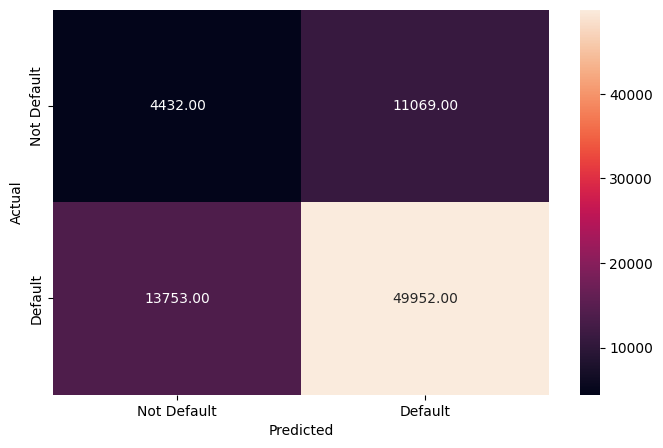

In [71]:
#creating metric function 
def metrics_score(actual, predicted):
    print(metrics.classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
metrics_score(y_test, y_pred_4)

In [72]:
print("-------------------------TEST SCORES-----------------------") 
print(f"Recall: { round(recall_score(y_test, y_pred_4, pos_label=1)*100, 4) }")
print(f"Precision: { round(precision_score(y_test, y_pred_4, pos_label=1)*100, 4) }")
print(f"F1-Score: { round(f1_score(y_test, y_pred_4, pos_label=1)*100, 4) }")
print(f"Accuracy score: { round(accuracy_score(y_test, y_pred_4)*100, 4) }")
print(f"AUC Score: { round(roc_auc_score(y_test, y_proba_2)*100, 4) }")

-------------------------TEST SCORES-----------------------
Recall: 78.4114
Precision: 81.8603
F1-Score: 80.0988
Accuracy score: 68.6615
AUC Score: 54.2187


In [101]:
y_train_pred = clf_model.predict(x_train)
y_train_proba = clf_model.predict_proba(x_train)[:, 1]

print(f"AUC Score: { round(roc_auc_score(y_train, y_train_proba)*100, 4) }")

AUC Score: 98.9828


In [102]:
y_test_pred = clf_model.predict(x_test)
y_test_proba = clf_model.predict_proba(x_test)[:, 1]

print(f"AUC Score: { round(roc_auc_score(y_test, y_test_proba)*100, 4) }")

AUC Score: 54.2187


## MODEL DEPLOYMENT

In [ ]:
# ! pip install fastapi uvicorn

In [114]:
from fastapi import FastAPI
from pydantic import BaseModel
import pickle
import json
import requests

### Load the model into a pickle file

In [115]:
# save the model to a file
with open("model.pkl", "wb") as pkl:
    pickle.dump(clf_model, pkl)

In [ ]:
# some JSON:
x =  requests.get("https://Password123@loanwise.qnhvgxw.mongodb.net/")

print(type(x.json()))

# # parse x:
# y = json.loads(x.text)

# # the result is a Python dictionary:
# print(y["age"])

In [120]:
# Convert JSON to String
a = {"name" : "GeeksforGeeks", "Topic" : "Json to String", "Method": 1}
y = json.dumps(a)
print(y)


#  # Get dummy data using an API
# res = requests.get("http://dummy.restapiexample.com/api/v1/employees")
 
# # Convert data to dict
# data = json.loads(res.text)


 
# print(data)
# print(type(data))

{"name": "GeeksforGeeks", "Topic": "Json to String", "Method": 1}


In [117]:
res

<Response [406]>

### Request Body

In [138]:
class request_body(BaseModel):
    Loan_Term : str
    Verification_by_Loan_Company : str
    Loan_Status : str
    Loan_Purpose : str
    Application_Type : str
    Total_Years_of_Employment : float
    Annual_Income : float
    Income_Debt_Ratio : float
    No_of_Open_Credit_Lines : int
    Credit_Utilization_Rate : float
    No_of_Mortgage_Account :int


# load the saved model
with open('model.pkl', 'rb') as pkl:
    model = pickle.load(pkl)

# Creating an Endpoint to receive the data
# to make prediction on.
app = FastAPI()

@app.post('/predict')
def predict(input_parameters : request_body):
    
    input_data = input_parameters.json()
    input_dictionary = json.loads(input_data)
    
    Loan_Term =  input_dictionary["Loan_Term"]
    Verification_by_Loan_Company = input_dictionary["Verification_by_Loan_Company"]
    Loan_Status = input_dictionary["Loan_Status"]
    Loan_Purpose = input_dictionary["Loan_Purpose"]
    Application_Type = input_dictionary["Application_Type"]
    Total_Years_of_Employment = input_dictionary["Total_Years_of_Employment"]
    Annual_Income = input_dictionary["Annual_Income"]
    Income_Debt_Ratio = input_dictionary["Income_Debt_Ratio"]
    No_of_Open_Credit_Lines = input_dictionary["No_of_Open_Credit_Lines"]
    Credit_Utilization_Rate = input_dictionary["Credit_Utilization_Rate"]
    No_of_Mortgage_Account = input_dictionary["No_of_Mortgage_Account"]

    input_list = [Loan_Term, Verification_by_Loan_Company, Loan_Status, Loan_Purpose, Application_Type,
                  Total_Years_of_Employment, Annual_Income, Income_Debt_Ratio, No_of_Open_Credit_Lines,
                  Credit_Utilization_Rate, No_of_Mortgage_Account]
    
    prediction = pkl.predict([input_list])
    
    if (prediction[0] == 0):
        return 'Applicant will not default'
    else:
        return 'Applicant will default'



In [ ]:
# # Creating an Endpoint to receive the data
# # to make prediction on.

# @app.post('/predict')
# def predict(data : request_body):
    
#     test_data = [[
#             data.Loan_Term, 
#             data.Verification_by_Loan_Company, 
#             data.Loan_Status, 
#             data.Loan_Purpose,
#             data.Application_Type,
#             data.Total_Years_of_Employment,
#             data.Annual_Income,
#             data.Income_Debt_Ratio,
#             data.No_of_Open_Credit_Lines,
#             data.Credit_Utilization_Rate,
#             data.No_of_Mortgage_Account

#     ]]
#     class_idx = clf.predict(test_data)[0]
#     return { 'class' : iris.target_names[class_idx]}

In [ ]:
 
# Convert dict to string
data = json.dumps(data)